In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------
# converts degrees to radians
deg2rad = np.pi / 180.0
# ----------------------------------
# converts degrees to radians
rad2deg = 1.0 / deg2rad

In [2]:
def density_function_dists(dists, gammas=20, radkm=100, epsilons=8000, resmin = 1.0,
                           reslim = 15.0, xlim = 200.0, mode='new'):
    # Boolean indexes
    # point closer to the center
    closer_to_center = (dists <= radkm)

    # point in transition zone
    transition_zone = (dists <= radkm + epsilons) & (dists > radkm)

    # point far from the center
    far_from_center = (dists > radkm + epsilons)    
    
    dens_f = np.zeros(np.shape(dists))
    
    if mode == 'old':
        # auxilary function
        sx = (dists - radkm) / epsilons

        # set density
        dens_f[closer_to_center] = gammas ** 4
        dens_f[transition_zone] = ((1.0 - sx[transition_zone]) *
                                   gammas + sx[transition_zone]) ** 4
        dens_f[far_from_center] = 1.0

        # normalization - make it in [0,1]
        dens_f = dens_f / gammas ** 4
        
    elif mode == 'new':
        resmin = 1.0
        reslim = 15.0
        xlim = 200.0
        
        dens_f[closer_to_center] = resmin
        dens_f[transition_zone] = resmin + (dists[transition_zone] - radkm)*(reslim - resmin)/xlim
        dens_f[far_from_center] = resmin + epsilons*(reslim - resmin)/xlim
        dens_f = dens_f / resmin
        dens_f = 1 / dens_f**2
        
        
    return dens_f

def density_function(lat, lon, **kwargs):
    lat, lon = map(np.radians, [lat, lon])

    haver_formula = np.sin(lat / 2.0) ** 2 + \
                    np.cos(lat) * np.sin(lon / 2.0) ** 2

    dists = 2 * np.arcsin(np.sqrt(haver_formula)) * 6367

    dens_f = density_function_dists(dists, **kwargs)
    return dens_f

In [3]:
nlat = 1024*2
nlon = 2048*2

lats = np.linspace(-90.0, 90.0, nlat + 1)
lons = np.linspace(-180.0, 180.0, nlon + 1)
lons, lats = np.meshgrid(lons, lats)

# compute the density function in the lat-lon grid
print("Computing the density function in the lat-lon grid...")
data = density_function(lats, lons, radkm=10, resmin = 1.0,
                           reslim = 15.0, xlim = 200.0)
print("Done\n")

Computing the density function in the lat-lon grid...
Done



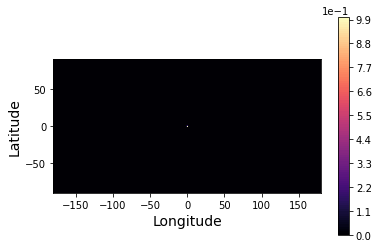

In [4]:
plt.figure()

# plot contours
#plt.contour(lons, lats, data, colors='black')
cp = plt.contourf(lons, lats, data, 100, cmap='magma')

# label the axis
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# plot colobar
cbar = plt.colorbar(cp)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# show, save and close
plt.gca().set_aspect('equal')
plt.show()
plt.close()

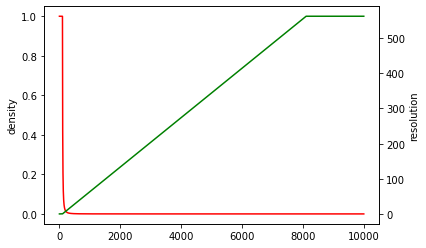

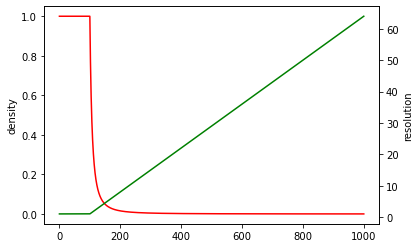

In [5]:
dists = np.linspace(0.0, 10000.0, 50000)
dens = density_function_dists(dists)

plt.plot(dists, dens, 'red')
plt.ylabel('density')
ax2 = plt.gca().twinx()
ax2.plot(dists, 1/np.sqrt(dens), 'green')
ax2.set_ylabel('resolution')
plt.show()
plt.close()


dists = np.linspace(0.0, 1000.0, 5000)
dens = density_function_dists(dists)

plt.plot(dists, dens, 'red')
plt.ylabel('density')
ax2 = plt.gca().twinx()
ax2.plot(dists, 1/np.sqrt(dens), 'green')
ax2.set_ylabel('resolution')
plt.show()
plt.close()

114.77794033184232
10000.0


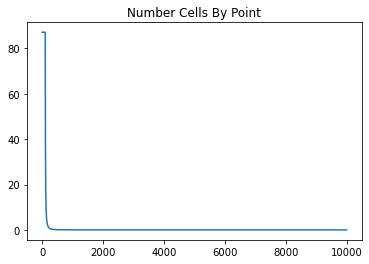

In [6]:
def density_to_resolution(dens, N=200000):
    sum_dens = dens.sum()
    print(sum_dens)

    res = N * dens / sum_dens
    return res

# From 0 to 10k km of the center we create a 1D grid
dists = np.arange(0, 10000.0, 1)
dens = density_function_dists(dists)

# In the grid covered by "dens" we want to put 10k cells
cells_by_point = density_to_resolution(dens, N=10000)

num_cells = cells_by_point.sum()
print(num_cells)

plt.plot(dists, cells_by_point)
plt.title("Number Cells By Point")
plt.show()
plt.close()

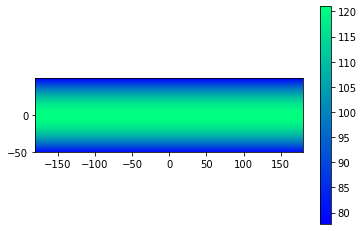

Computing the density function in the lat-lon grid...


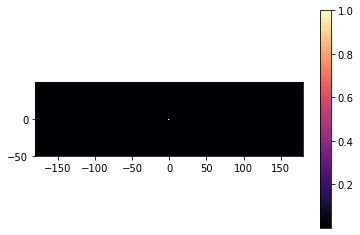

160000.0000000013


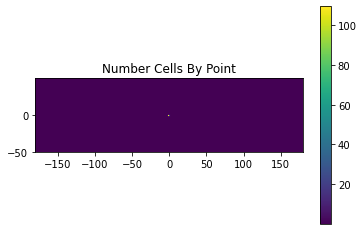

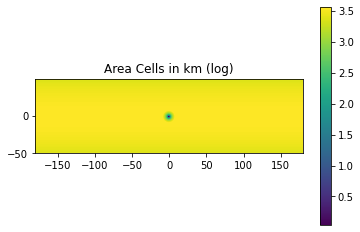

In [7]:
N_cells = 160000
step = 0.1
lats0 = np.arange(-50.0, 50.0, step)
lons0 = np.arange(-180.0, 180.0, step)

lons, lats = np.meshgrid(lons0, lats0)

def areas(lon, lat, step=0.1):
    area1 = (step*110)**2*abs(np.cos(np.radians(lat)))
    area = np.tile(area1, (lon.shape[0], 1)).transpose()
    return area

area = areas(lons0, lats0, step=step)

fig, ax = plt.subplots()
im = ax.pcolormesh(lons, lats, area, shading='nearest', cmap='winter')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)
plt.show()


# compute the density function in the lat-lon grid
print("Computing the density function in the lat-lon grid...")
data = density_function(lats, lons, gammas=30, radkm=100, epsilons=800)


fig, ax = plt.subplots()
im = ax.pcolormesh(lons, lats, data, shading='nearest', cmap='magma')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)
plt.show()

sum_dens = data.sum()
cells_by_point = data*N_cells/sum_dens
num_cells = cells_by_point.sum()
print(num_cells)

fig, ax = plt.subplots()
im = ax.pcolormesh(lons, lats, cells_by_point, shading='nearest', cmap='viridis')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)

plt.title("Number Cells By Point")
plt.show()
plt.close()

area_cells = area/cells_by_point

fig, ax = plt.subplots()
im = ax.pcolormesh(lons, lats, np.log10(area_cells), shading='nearest', cmap='viridis')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)

plt.title("Area Cells in km (log)")
plt.show()
plt.close()

(1000, 3600)
(3600,)


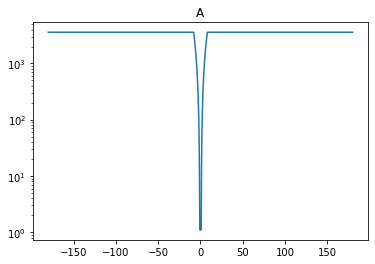

Number smaller than 15km
1789
(100,)


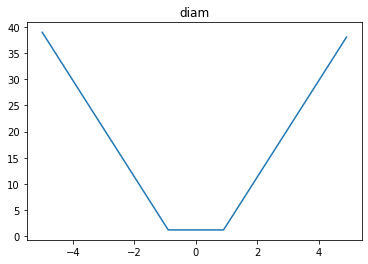

In [8]:
print(area_cells.shape)
rangeareas = area_cells[len(lats0)//2, :]
print(rangeareas.shape)
plt.plot(lons0, rangeareas)
plt.yscale('log')
plt.title("A")
plt.show()
plt.close()

resolution_cells = 2*np.sqrt(area_cells/np.pi)
print('Number smaller than 15km')
print((resolution_cells < 15.0).sum())
rangeres = resolution_cells[len(lats0)//2, len(lons0)//2-50:len(lons0)//2+50]
print(rangeres.shape)
plt.plot(lons0[len(lons0)//2-50:len(lons0)//2+50], rangeres)
plt.title("diam")
plt.show()
plt.close()

NEW
Needed cells for lower resolution 1km
14583.033176633184
Number smaller than 15km
8933


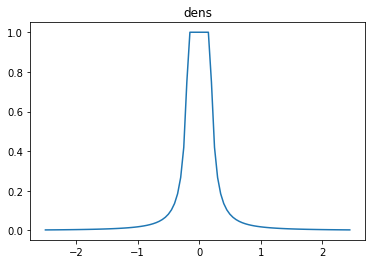

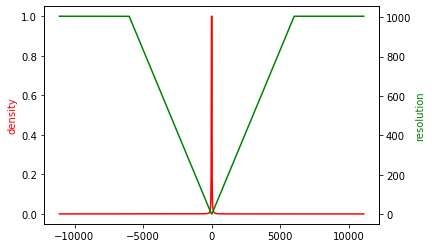

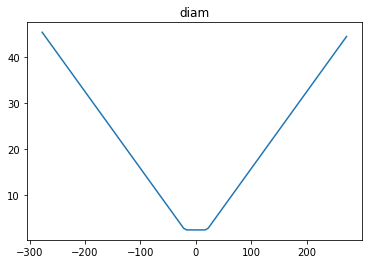

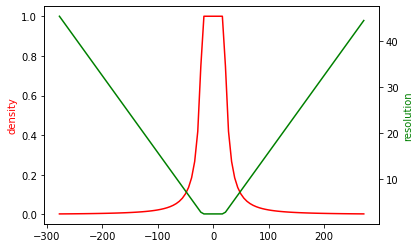

In [10]:
def dens2res(N_cells, step=0.1, plot=True, **kwargs):
    
    lats0 = np.arange(-100.0, 100.0, step)
    lons0 = np.arange(-100.0, 100.0, step)

    lons, lats = np.meshgrid(lons0, lats0)

    area = areas(lons0, lats0, step=step)

    dens = density_function(lats, lons, **kwargs)
    
    sum_dens = dens.sum()
    
    # old method
    neededNcells = (2*110*step)**2/np.pi * sum_dens
    
    print('Needed cells for lower resolution 1km')
    print(neededNcells)
    
    cells_by_point = dens*N_cells/sum_dens
    
    area_cells = area/cells_by_point
    
    resolution_cells = 2*np.sqrt(area_cells/np.pi)
    
    print('Number smaller than 15km')
    print((resolution_cells < 15.0).sum())

    if plot:
        rangedens= dens[len(lats0)//2, len(lons0)//2-50:len(lons0)//2+50]
        plt.plot(lons0[len(lons0)//2-50:len(lons0)//2+50], rangedens)
        plt.title("dens")
        plt.show()
        plt.close()
        
        dists = lons0*111

        plt.plot(dists, dens[len(lats0)//2,:], 'red')
        plt.ylabel('density')
        plt.gca().yaxis.label.set_color('red')
        ax2 = plt.gca().twinx()
        ax2.plot(dists, resolution_cells[len(lats0)//2,:], 'green')
        ax2.yaxis.label.set_color('green')
        ax2.set_ylabel('resolution')
        plt.show()
        plt.close()

        rangedists = dists[len(lons0)//2-50:len(lons0)//2+50]
        rangeres= resolution_cells[len(lats0)//2, len(lons0)//2-50:len(lons0)//2+50]
        
        plt.plot(rangedists, rangeres)
        plt.title("diam")
        plt.show()
        plt.close()
        
        plt.plot(rangedists, rangedens, 'red')
        plt.gca().yaxis.label.set_color('red')
        plt.ylabel('density')
        ax2 = plt.gca().twinx()
        ax2.plot(rangedists, rangeres, 'green')
        ax2.yaxis.label.set_color('green')
        ax2.set_ylabel('resolution')
        plt.show()
        plt.close()
        
    return resolution_cells

print('NEW')
res = dens2res(2562, step=0.05, radkm=20, resmin=1.0, 
               epsilons=500*12, reslim = 1.0, xlim = 12.0)

#print('OLD')
#res = dens2res(163842, step=0.05, radkm=10, epsilons=3000, gammas=20, mode='old')